# Darstellung des HACI-Prinzips

In diesem Notebook wird das Prinzip, das den HACI-Objekten zugrunde liegt dargestellt. Dafür brauchen wir einige zusätzliche Pakete.

In [1]:
import numpy as np
import xarray as xr
import haci as hci
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

from plotting_tools.colormaps import radar_cmap as rc

from io_tools import radolan
import fixed_colourbar as fc

from analysis_tools import grid_and_interpolation as gi

from scipy import ndimage as ndi

/vols/talos/local/anaconda2-5.0.0/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def colourbar(mappable,**kwargs):
    ax = mappable.ax
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax,**kwargs)

Als nächstes definieren wir uns die Zeitpunkte des Beispiels.

In [3]:
date = dt.date(2013,6,18)

Dann laden wir uns die nötigen Radardaten.

In [4]:
rx_path = "/vols/talos/datasets/radolan/rx_hdcp2/"

In [5]:
rx = xr.open_dataset("{root}/{dt:%Y}/hdfd_miub_drnet00_l3_dbz_v00_{dt:%Y%m%d}000000.nc".format(root=rx_path,
                                                                                               dt=date))

In [6]:
t0 = "13:45"
t1 = "13:50"

In [7]:
t_idx0 = int(t0.split(":")[0]) * 12 + int(t0.split(":")[1])/5
t_idx1 = int(t1.split(":")[0]) * 12 + int(t1.split(":")[1])/5

Dann erzeugen wir uns einen Ausschnitt und die Kartenprojektion dazu, um ihn später darzustellen.

In [9]:
lon_mn = 11
lon_mx = 12
lat_mn = 50.2
lat_mx = 50.7

In [10]:
mp = Basemap(projection='stere',
             lon_0=10, \
             lat_0=90, \
             lat_ts=60, \
             llcrnrlon = lon_mn, llcrnrlat = lat_mn, \
             urcrnrlon = lon_mx, urcrnrlat = lat_mx,
             rsphere = (6378169., 6356583.8),\
             resolution='i')

Jetzt fehlen noch die Koordinaten des Ausschnitts.

In [11]:
rmin, cmin = gi.get_index((lon_mn,lat_mn),rx.lon.data,rx.lat.data)
rmax, cmax = gi.get_index((lon_mx,lat_mx),rx.lon.data,rx.lat.data)

In [12]:
x,y = mp(rx.lon.data[rmin:rmax,cmin:cmax],rx.lat.data[rmin:rmax,cmin:cmax])

Für die Darstellung ist es wahrscheinlich übersichtlicher, wenn die Bereiche ohne Radarechos nicht sichtbar sind. Deshalb erzeugen wir uns eine Maske dafür.

In [13]:
mask = np.ma.masked_less(np.ma.masked_greater_equal(rx.dbz.data[t_idx0][rmin:rmax,cmin:cmax],92.5),5).mask                       

Als nächstes suchen wir uns die Bereiche mit aktiver Konvektion.

In [14]:
camask = hci.ca_mask(rx.dbz,35)

Danach erzeugen wir die Pufferradien.

In [15]:
selem = np.zeros((3,3,3))
selem[1,:,:]=1
objmap, nr_obj =  hci.label_objects(camask,selem)

Und puffern die Bereiche mit aktiver Konvektion.

In [16]:
fillmask = np.ma.masked_greater_equal(rx.dbz.data,92.5).mask

In [17]:
bufmask = hci.buffer_mask(camask|fillmask,radius=15)

Danach suchen wir uns neu entstandene CIs.

In [18]:
cimask = hci.ci_mask(camask,bufmask)
ci_labels = np.unique(objmap[cimask])

In [19]:
# 5. link CI objects with their subsequent children
objects = hci.link_objects(objmap,ci_labels,5)[0]

0
1
2
3
4


In [ ]:
# 6. extract object properties ...
objprops = hci.object_props(rx.time,objects,cimask)

In [ ]:
obj_props_t1 = objprops[objprops.t0 == t_idx1]

In [ ]:
long_obj = obj_props_t1[obj_props_t1.t1 - obj_props_t1.t0 >= 5]

In [ ]:
long_ci = objects[t_idx1].copy()

In [ ]:
oids = long_obj.id.values

In [24]:
not_oidx = np.where(np.logical_and(long_ci!=oids[0],long_ci!=oids[1]))

In [25]:
long_ci[not_oidx] = 0
long_ci[long_ci!=0] = 1

In [26]:
import matplotlib as mpl

In [27]:
mpl.rcParams.update({'font.size': 16})
mpl.rcParams.update({'figure.autolayout': True})

In [28]:
buffer_centre = ndi.measurements.center_of_mass(bufmask[t_idx0][rmin:rmax,cmin:cmax],1)
buf_lon  = rx.lon.data[rmin:rmax,cmin:cmax][int(np.rint(buffer_centre[0])),
                                            int(np.rint(buffer_centre[1]))]
buf_lat  = rx.lat.data[rmin:rmax,cmin:cmax][int(np.rint(buffer_centre[0])),
                                            int(np.rint(buffer_centre[1]))]
buf_x,buf_y = mp(buf_lon,buf_lat)

In [29]:
radius_lon = rx.lon.data[rmin:rmax,cmin:cmax][int(np.rint(buffer_centre[0])),
                                              int(np.rint(buffer_centre[1]+17))]
radius_lat = rx.lat.data[rmin:rmax,cmin:cmax][int(np.rint(buffer_centre[0])),
                                              int(np.rint(buffer_centre[1]+17))]
radius_x,radius_y = mp(radius_lon,radius_lat)

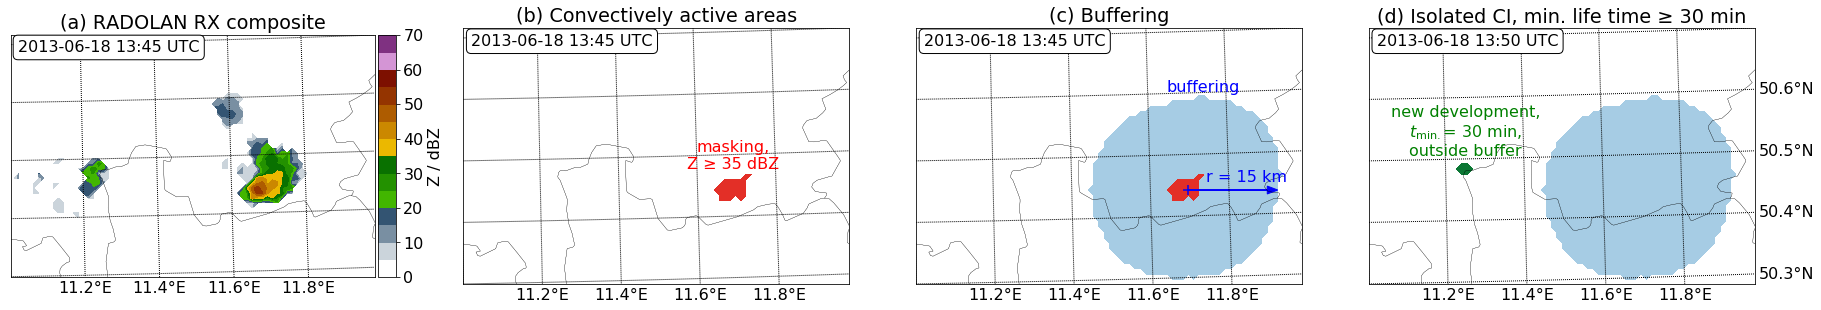

In [50]:
# fig,ax = plt.subplots(2,2,figsize=(15.5,10.6),sharex='col',sharey='row')
fig,ax = plt.subplots(1,4,figsize=(24.8,6),sharex='col',sharey='row')

z_plot = mp.contourf(x,y,
              np.ma.masked_less(np.ma.masked_greater_equal(rx.dbz.data[t_idx0],92.5),5)
                       [rmin:rmax,cmin:cmax], 
                     levels=np.arange(0,75,5),
                     cmap = rc(),vmin=5, vmax=70,ax=ax[0])
mp.drawparallels(np.arange(lat_mn,lat_mx,0.1),labels=[False,False,False,False],ax=ax[0])
mp.drawmeridians(np.arange(lon_mn,lon_mx,0.2),labels=[True,False,False,True],ax=ax[0])
mp.drawcountries(ax=ax[0])
mp.readshapefile('/vols/talos/home/stephan/lib/vg2500_geo84/vg2500_bld', 'GEN',linewidth=0.2,ax=ax[0])
#fc.colourbar(z_plot)
ax[0].set_title("(a) RADOLAN RX composite")
ax[0].text(0.02,0.93,"2013-06-18 13:45 UTC",transform=ax[0].transAxes,
        bbox=dict(boxstyle="round",
                   ec=(0, 0, 0),
                   fc=(1., 1, 1),
                   )
         )
cbar = colourbar(z_plot)
cbar.set_label('Z / dBZ')

mp.contourf(x,y,
            np.ma.masked_where(mask==True,
                               np.ma.masked_less(camask[t_idx0][rmin:rmax,cmin:cmax],1)),
            cmap = 'Reds',vmin=0, vmax=1.5, ax = ax[1])
mp.drawparallels(np.arange(lat_mn,lat_mx,0.1),labels=[False,False,False,False],ax=ax[1])
mp.drawmeridians(np.arange(lon_mn,lon_mx,0.2),labels=[True,False,False,True],ax=ax[1])
mp.drawcountries(ax=ax[1])
mp.readshapefile('/vols/talos/home/stephan/lib/vg2500_geo84/vg2500_bld', 'GEN',linewidth=0.2,ax=ax[1])
ax[1].set_title(u"(b) Convectively active areas")
ax[1].text(0.02,0.93,"2013-06-18 13:45 UTC",transform=ax[1].transAxes,
             bbox=dict(boxstyle="round",
                   ec=(0, 0, 0),
                   fc=(1., 1, 1),
                   )
         )

ax[1].text(0.7,0.45,u"masking,\nZ ≥ 35 dBZ",
             transform=ax[1].transAxes,
             color='red',
             ha='center'
             )

mp.contourf(x,y,
            np.ma.masked_less(bufmask[t_idx0][rmin:rmax,cmin:cmax],1),
            cmap = 'Blues',
            vmin=0, vmax=1.7,
            ax=ax[2],alpha=0.5,
            linestyles='dashed')
mp.contourf(x,y,
              np.ma.masked_where(mask==True,
                                 np.ma.masked_less(camask[t_idx0][rmin:rmax,cmin:cmax],1)),
            cmap = 'Reds',vmin=0, vmax=1.5, ax=ax[2])
mp.plot(buf_x,buf_y,'b+',ax=ax[2],mew=1.5,markersize=10)
mp.drawparallels(np.arange(lat_mn,lat_mx,0.1),labels=[False,False,False,False],ax=ax[2])
mp.drawmeridians(np.arange(lon_mn,lon_mx,0.2),labels=[True,False,False,True],ax=ax[2])
mp.drawcountries(ax=ax[2])
mp.readshapefile('/vols/talos/home/stephan/lib/vg2500_geo84/vg2500_bld', 'GEN',linewidth=0.2,ax=ax[2])
ax[2].set_title(u"(c) Buffering")
ax[2].text(0.02,0.93,"2013-06-18 13:45 UTC",transform=ax[2].transAxes,
        bbox=dict(boxstyle="round",
                   ec=(0, 0, 0),
                   fc=(1., 1, 1),
                   )
         )
ax[2].text(0.65,0.75,"buffering",
             transform=ax[2].transAxes,
             color='blue',
             )
ax[2].arrow(buf_x,buf_y,radius_x-buf_x,radius_y-buf_y,color='blue',
          head_width=1500, head_length=2000,
          length_includes_head=True)
ax[2].text(0.75,0.4,"r = 15 km",
             transform=ax[2].transAxes,
             color='blue',)

mp.contourf(x,y,
              np.ma.masked_where(mask==True,
                                 np.ma.masked_less(cimask[t_idx1][rmin:rmax,cmin:cmax],1)),
            cmap = 'Greens',vmin=0, vmax=1.2,ax=ax[3])
mp.contourf(x,y,
            np.ma.masked_less(bufmask[t_idx0][rmin:rmax,cmin:cmax],1),
            cmap = 'Blues',vmin=0, vmax=1.7,ax=ax[3],alpha=0.5)
mp.drawparallels(np.arange(lat_mn,lat_mx,0.1),
                           labels=[False,True,True,False],
                           ax=ax[3])#,
                           #rotation=45)
mp.drawmeridians(np.arange(lon_mn,lon_mx,0.2),labels=[True,False,False,True],ax=ax[3])
mp.drawcountries(ax=ax[3])
mp.readshapefile('/vols/talos/home/stephan/lib/vg2500_geo84/vg2500_bld', 'GEN',linewidth=0.2,ax=ax[3])
ax[3].set_title(u"(d) Isolated CI, min. life time ≥ 30 min")
ax[3].text(0.02,0.93,"2013-06-18 13:50 UTC",transform=ax[3].transAxes,
        bbox=dict(boxstyle="round",
                   ec=(0, 0, 0),
                   fc=(1., 1, 1))
         )
ax[3].text(0.25,0.5,u"new development,\n$t_\mathrm{min.}$= 30 min,\noutside buffer",
             transform=ax[3].transAxes,
             color='green', ha='center'
             )
plt.tight_layout()
plt.subplots_adjust(right=0.7)
plt.savefig("/vols/talos/home/stephan/pics/haci_bsp_2.pdf")

In [102]:
radius_x-buf_x

192124.82082363695

In [78]:
centre = ndi.measurements.center_of_mass(bufmask[t_idx0],1)

In [79]:
centre


(407.6062747362308, 323.3113231932271)